Install Dependencies

In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Import Libraries

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, auc, classification_report, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier


/home/javi/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Load Dataset

In [3]:
# Load the processed dataset
df = pd.read_csv("data/processed_dataset.csv", index_col=0)
print("Dataset loaded successfully from 'data/processed_dataset.csv'")

df.head()

Dataset loaded successfully from 'data/processed_dataset.csv'


,blueTeamControlWardsPlaced,blueTeamWardsPlaced,blueTeamTotalKills,blueTeamDragonKills,blueTeamHeraldKills,blueTeamTowersDestroyed,blueTeamInhibitorsDestroyed,blueTeamTurretPlatesDestroyed,blueTeamFirstBlood,blueTeamMinionsKilled,...,diffJungleMinions,diffTotalGold,diffTotalKills,diffXp,diffTotalDamageToChamps,diffDragonKills,diffHeraldKills,diffTowersDestroyed,diffInhibitorsDestroyed,diffTurretPlatesDestroyed
matchId,,,,,,,,,,,,,,,,,,,,,
EUW1_6882489515',2,23,4,2,0,0,0,7,0,388,...,12,-5714,-12,-2815,-5397,2,0,-2,0,6
EUW1_6882416210',2,46,12,1,0,1,0,10,0,348,...,22,-1118,-5,210,-768,1,0,0,0,6
EUW1_6881092720',2,19,13,0,0,0,0,11,0,331,...,12,-2384,-5,37,-4945,-1,0,-2,0,8
EUW1_6879405717',3,28,8,0,1,1,0,9,1,355,...,-3,2176,-2,-603,3109,-1,1,1,0,4
EUW1_6879389461',3,30,11,1,1,1,0,7,0,370,...,4,1720,4,1591,7431,0,1,0,0,2


Train-test Split

In [4]:
X = df.drop(columns=["blueWin"])
y = df["blueWin"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X shape: (24218, 38)
y shape: (24218,)


Scaling

In [5]:
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Feature Selection

In [6]:
def find_bestKfeatures(model):
  print("Performing feature selection...")
  # Select best k features
  k = -1
  max_score = 0
  for i in range(1, 16, 2):
    selector = SelectKBest(k=i)
    pipeline = Pipeline([('selector', selector), ('model', model)])
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print("K: {}, score: {}".format(i, score))
    if score > max_score:
      k = i
      max_score = score
      selected_features_indices = selector.get_support(indices=True)
  print("Best K number: {}, score: {}".format(k, max_score))
  print("Selected features: ", list(X.columns[selected_features_indices]))
  print()
  # return feature index list
  return list(selected_features_indices)

def apply_feature_selection(X, selected_features_indices):
  return X[:, selected_features_indices]

Hyper-Parameter Tuning

In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)

def train_model_with_random_search(model, param_grid, X_train, y_train):
    print("Starting training...")

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, 
                                       scoring='accuracy', n_jobs=-1, cv=cv)

    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)

    print("Training completed")
    print()

    # Get best estimator
    best_model = random_search.best_estimator_
    # Get best training score
    best_score = random_search.best_score_
    print('Best Training Score: ', best_score)
    # Get best param
    best_param = random_search.best_params_
    print('Best Parameters: ', best_param)
    print()

    # Return model
    return best_model, best_param

Model Evaluation

In [8]:
def evaluate_model(model, X_test):
    print("Model Evaluation: ")

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    print('Accuracy: ', accuracy)
    print('F1 Score: ', f1)
    print('AUC(ROC): ', roc_auc)
    print()
    print("Classification Report: ")
    print(classification_report(y_test, y_pred))

    # ROC AUC plot
    fper, tper, _ = roc_curve(y_test, y_pred_prob)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fper, tper, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc="lower right")

    plt.show()

    return accuracy, f1, roc_auc

Random Forest Classifier

Performing feature selection...
K: 1, score: 0.6921965317919075
K: 3, score: 0.7097440132122214
K: 5, score: 0.7398843930635838
K: 7, score: 0.7378199834847233
K: 9, score: 0.7380264244426095
K: 11, score: 0.7396779521056978
K: 13, score: 0.740503715937242
K: 15, score: 0.75
Best K number: 15, score: 0.75
Selected features:  ['blueTeamTotalKills', 'blueTeamTotalGold', 'blueTeamXp', 'redTeamTotalKills', 'redTeamTurretPlatesDestroyed', 'redTeamTotalGold', 'redTeamXp', 'diffMinionsKilled', 'diffTotalGold', 'diffTotalKills', 'diffXp', 'diffTotalDamageToChamps', 'diffDragonKills', 'diffTowersDestroyed', 'diffTurretPlatesDestroyed']

Starting training...
Training completed

Best Training Score:  0.7601935950172364
Best Parameters:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}

Model Evaluation: 
Accuracy:  0.7487613542526838
F1 Score:  0.7487481257038276
AUC(ROC):  0.8332002422070925

Classification Report: 
 

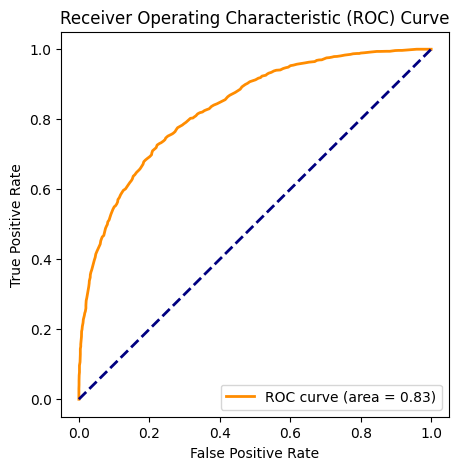

In [9]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini'],
    'max_depth': [None, 3, 4, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

model = RandomForestClassifier()

# Perform feature selection
selected_features = find_bestKfeatures(model)
X_train_rd, X_test_rd = apply_feature_selection(X_train, selected_features), apply_feature_selection(X_test, selected_features)

# Train model with RandomizedSearchCV
trained_model, param_sample = train_model_with_random_search(model, param_grid, X_train_rd, y_train)

# Evaluate model
accuracy, f1, roc_auc = evaluate_model(trained_model, X_test_rd)